In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df1 = pd.read_csv('/home/sasidharreddy/study/OELP_sem6/leadday3/leadday_3.csv')
df=df1[['idates','imonths','iyears','obs','meanmod','stdmod']]
df.to_csv('new_output_file.csv', index=False)
df['datetime'] = pd.to_datetime( df['idates'].astype(str)+ '-' + df['imonths'].astype(str)+'-'+df['iyears'].astype(str))
df = df.drop(['idates', 'imonths', 'iyears'], axis=1)
df.to_csv('output_file.csv', index=False)

df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,obs,meanmod,stdmod
datetime,,,
2007-03-01,0.0,0.0,0.0
2007-04-01,0.0,0.0,0.0
2007-05-01,0.0,0.0,0.0
2007-06-01,0.0,0.0,0.0
2007-07-01,0.0,0.0,0.0


In [4]:
df1

,idates,imonths,iyears,obs,meanmod,stdmod
0,3,1,2007,0.0,0.0,0.0
1,4,1,2007,0.0,0.0,0.0
2,5,1,2007,0.0,0.0,0.0
3,6,1,2007,0.0,0.0,0.0
4,7,1,2007,0.0,0.0,0.0
...,...,...,...,...,...,...
4990,23,12,2020,0.0,0.0,0.0
4991,24,12,2020,0.0,0.0,0.0
4992,25,12,2020,0.0,0.0,0.0
4993,26,12,2020,0.0,0.0,0.0


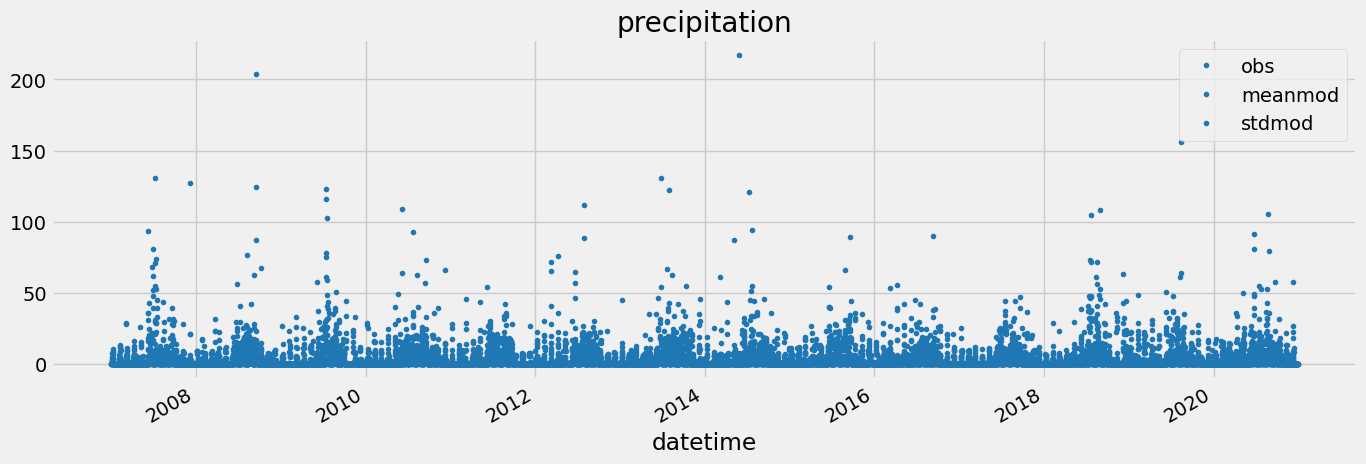

In [5]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='precipitation')
plt.show()

<AxesSubplot:ylabel='Frequency'>

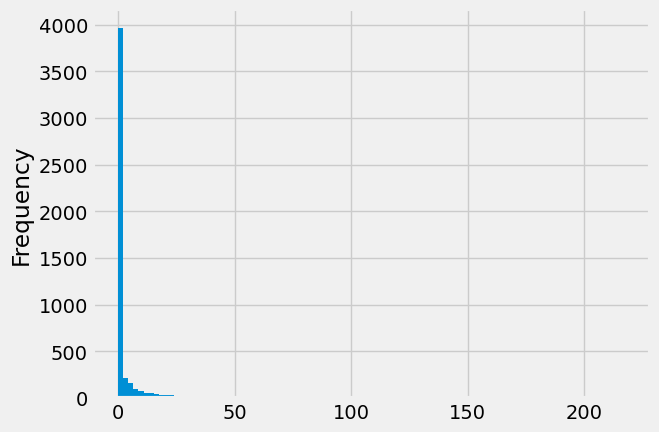

In [6]:
df['obs'].plot(kind='hist', bins=100)

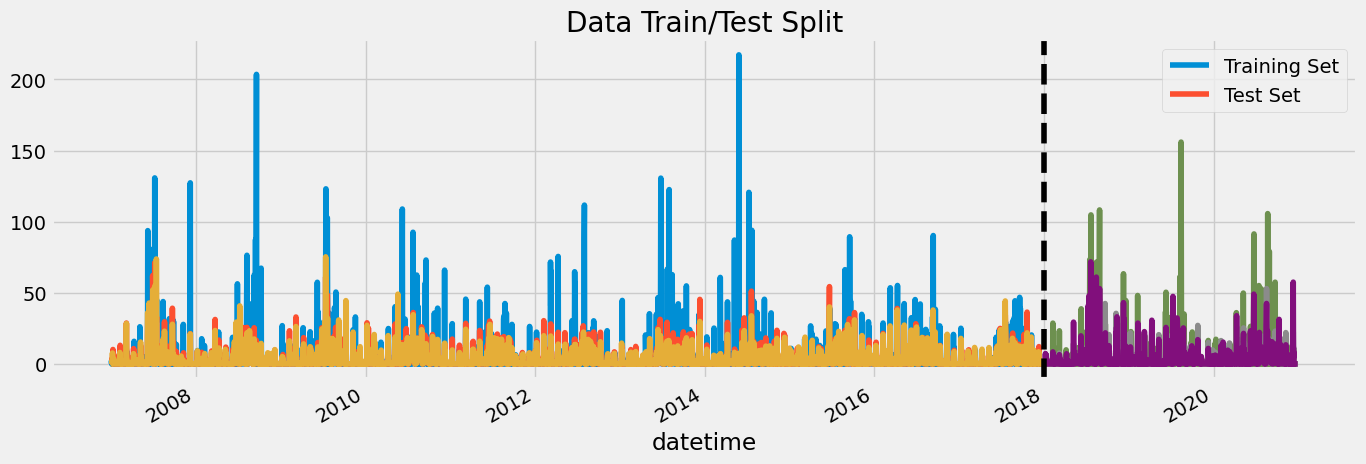

In [7]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [8]:
from sklearn.model_selection import TimeSeriesSplit
#test size 1 day*365 days*1 year
tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)
df = df.sort_index()

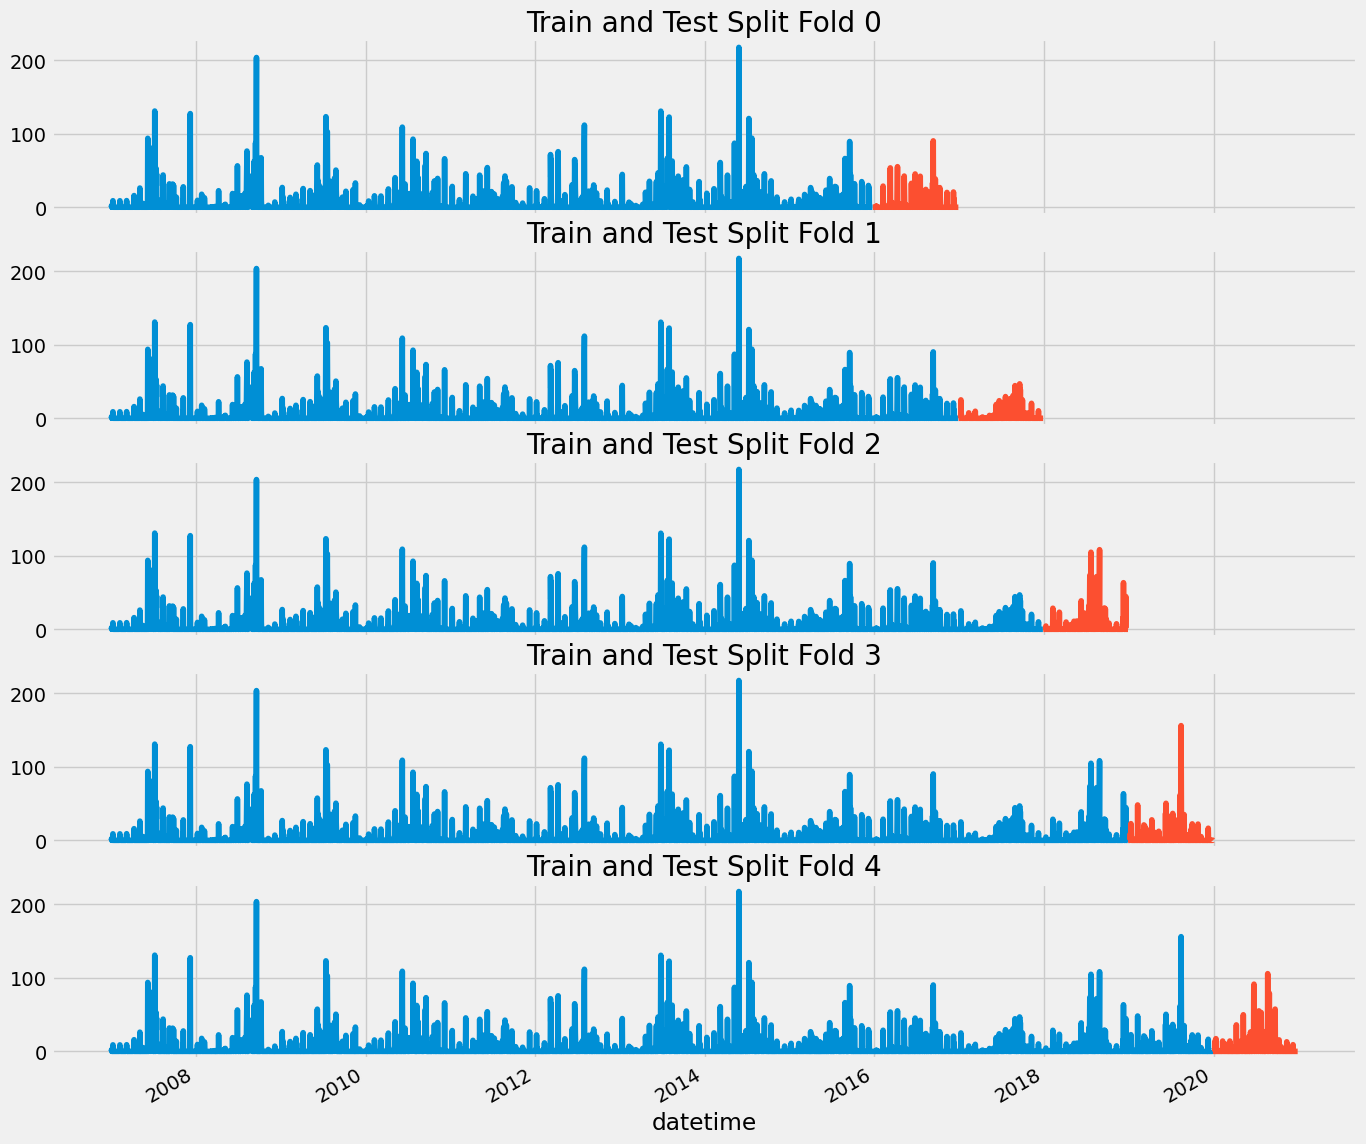

In [9]:
#time series cross validation
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['obs'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train and Test Split Fold {fold}')
    test['obs'].plot(ax=axs[fold],
                         label='Test Set')
    #axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [11]:
df1['meanmod']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4990    0.0
4991    0.0
4992    0.0
4993    0.0
4994    0.0
Name: meanmod, Length: 4995, dtype: float64

In [12]:
df['dayofmonth']

datetime
2007-01-02     2
2007-01-03     3
2007-01-04     4
2007-01-05     5
2007-01-06     6
              ..
2020-12-23    23
2020-12-24    24
2020-12-25    25
2020-12-26    26
2020-12-27    27
Name: dayofmonth, Length: 4995, dtype: int64

In [13]:
def add_lags(df):
    target_map = df['obs'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [14]:
df = add_lags(df)

In [15]:
df.head()

,obs,meanmod,stdmod,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
datetime,,,,,,,,,,,,,
2007-01-02,0.00,0.00,0.00,1,1,1,2007,2,2,1,NaN,NaN,NaN
2007-01-03,2.27,0.07,0.16,2,1,1,2007,3,3,1,NaN,NaN,NaN
2007-01-04,0.00,0.00,0.00,3,1,1,2007,4,4,1,NaN,NaN,NaN
2007-01-05,1.75,3.63,1.78,4,1,1,2007,5,5,1,NaN,NaN,NaN
2007-01-06,0.00,0.96,0.79,5,1,1,2007,6,6,1,NaN,NaN,NaN


In [16]:
# tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)
# df = df.sort_index()


# fold = 0
# preds = []
# scores = []
# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     train = create_features(train)
#     test = create_features(test)

#     FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
#                 'lag1','lag2','lag3','meanmod','stdmod']
#     TARGET = 'obs'

#     X_train = train[FEATURES]
#     y_train = train[TARGET]

#     X_test = test[FEATURES]
#     y_test = test[TARGET]

#     reg = xgb.XGBRegressor(base_score=0, booster='gbtree',    
#                            n_estimators=1000,
#                            early_stopping_rounds=50,
#                            objective='reg:linear',
#                            max_depth=3,
#                            learning_rate=0.04)
#     reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=100)

#     y_pred = reg.predict(X_test)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)

In [17]:
tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = [
                'lag1','lag2','lag3','meanmod','stdmod']
    TARGET = 'obs'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.04)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:13.58643	validation_1-rmse:9.57136


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[84]	validation_0-rmse:10.79558	validation_1-rmse:8.21187
[0]	validation_0-rmse:13.23155	validation_1-rmse:6.63371
[69]	validation_0-rmse:10.59748	validation_1-rmse:5.94635


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:12.76595	validation_1-rmse:12.72138
[100]	validation_0-rmse:10.15599	validation_1-rmse:10.17101


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:12.75404	validation_1-rmse:11.94689


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:10.00010	validation_1-rmse:10.22438
[133]	validation_0-rmse:9.89848	validation_1-rmse:10.22792
[0]	validation_0-rmse:12.69108	validation_1-rmse:12.25225
[100]	validation_0-rmse:9.90379	validation_1-rmse:9.16070


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:9.51281	validation_1-rmse:9.00964
[300]	validation_0-rmse:9.12730	validation_1-rmse:8.89406
[400]	validation_0-rmse:8.79937	validation_1-rmse:8.52595
[500]	validation_0-rmse:8.48558	validation_1-rmse:8.28164
[600]	validation_0-rmse:8.15924	validation_1-rmse:8.22995
[605]	validation_0-rmse:8.14326	validation_1-rmse:8.23284


In [18]:
scores

[8.018689968111891,
 5.495448932826025,
 10.041710620436529,
 10.190525586962819,
 8.212518575916667]

In [19]:
print(f'mean square error across folds {np.mean(scores):0.4f}')
print(f'Fold mean square error:{scores}')

mean square error across folds 8.3918
Fold mean square error:[8.018689968111891, 5.495448932826025, 10.041710620436529, 10.190525586962819, 8.212518575916667]


In [20]:
# # Retrain on all data
# df = create_features(df)

# FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
#             'lag1','lag2','lag3','meanmod','stdmod']
# TARGET = 'obs'

# X_all = df[FEATURES]
# y_all = df[TARGET]

# reg = xgb.XGBRegressor(base_score=0.5,
#                        booster='gbtree',    
#                        n_estimators=1000,
#                        objective='reg:linear',
#                        max_depth=5,
#                        learning_rate=0.04)
# reg.fit(X_all, y_all,
#         eval_set=[(X_all, y_all)],
#         verbose=100)


In [21]:
# Retrain on all data
df = create_features(df)

FEATURES = [
            'lag1','lag2','lag3','meanmod','stdmod']
TARGET = 'obs'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.04)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:12.49447


/home/sasidharreddy/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:40:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:8.13298
[200]	validation_0-rmse:7.24332
[300]	validation_0-rmse:6.42837
[400]	validation_0-rmse:5.75788
[500]	validation_0-rmse:5.28840
[600]	validation_0-rmse:4.93025
[700]	validation_0-rmse:4.55020
[800]	validation_0-rmse:4.25736
[900]	validation_0-rmse:3.99771
[999]	validation_0-rmse:3.67670


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the entire dataset
y_pred_all = reg.predict(X_all)

# Calculate RMSE
rmse_all = np.sqrt(mean_squared_error(y_all, y_pred_all))
print("RMSE of retrained data:", rmse_all)


RMSE of retrained data: 3.676700478299103


In [23]:
df.index.max()

Timestamp('2020-12-27 00:00:00')

In [24]:
df

,obs,meanmod,stdmod,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
datetime,,,,,,,,,,,,,
2007-01-02,0.00,0.00,0.00,1,1,1,2007,2,2,1,NaN,NaN,NaN
2007-01-03,2.27,0.07,0.16,2,1,1,2007,3,3,1,NaN,NaN,NaN
2007-01-04,0.00,0.00,0.00,3,1,1,2007,4,4,1,NaN,NaN,NaN
2007-01-05,1.75,3.63,1.78,4,1,1,2007,5,5,1,NaN,NaN,NaN
2007-01-06,0.00,0.96,0.79,5,1,1,2007,6,6,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.00,0.00,0.00,2,4,12,2020,358,23,52,0.00,0.0,0.0
2020-12-24,0.00,0.00,0.00,3,4,12,2020,359,24,52,0.00,0.0,0.0
2020-12-25,0.00,0.00,0.00,4,4,12,2020,360,25,52,0.35,0.0,0.0


In [25]:
# Add predicted values as a new column to the DataFrame
df['predicted_data'] = y_pred_all

In [26]:
# Replace negative predicted values with zero
df['predicted_data'] =df['predicted_data'].clip(lower=0)
df['predicted_data'] = df['predicted_data'].clip(lower=0).round(2)


In [27]:
df

,obs,meanmod,stdmod,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,predicted_data
datetime,,,,,,,,,,,,,,
2007-01-02,0.00,0.00,0.00,1,1,1,2007,2,2,1,NaN,NaN,NaN,0.00
2007-01-03,2.27,0.07,0.16,2,1,1,2007,3,3,1,NaN,NaN,NaN,0.00
2007-01-04,0.00,0.00,0.00,3,1,1,2007,4,4,1,NaN,NaN,NaN,0.00
2007-01-05,1.75,3.63,1.78,4,1,1,2007,5,5,1,NaN,NaN,NaN,1.46
2007-01-06,0.00,0.96,0.79,5,1,1,2007,6,6,1,NaN,NaN,NaN,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.00,0.00,0.00,2,4,12,2020,358,23,52,0.00,0.0,0.0,0.05
2020-12-24,0.00,0.00,0.00,3,4,12,2020,359,24,52,0.00,0.0,0.0,0.05
2020-12-25,0.00,0.00,0.00,4,4,12,2020,360,25,52,0.35,0.0,0.0,0.53


In [28]:
from sklearn.metrics import r2_score

# Calculate bias
bias = np.mean(y_pred_all - y_all)

# Calculate standard deviation
std = np.std(y_pred_all - y_all)

# Calculate mean
mean = np.mean(y_pred_all)

# Calculate R-squared
r2 = r2_score(y_all, y_pred_all)

print("Bias:", bias)
print("Standard Deviation:", std)
print("Mean:", mean)
print("R-squared:", r2)


Bias: -0.0033771796106902576
Standard Deviation: 3.6766989272692103
Mean: 3.7058942
R-squared: 0.9102745866904204


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

rmse_meanmod = np.sqrt(mean_squared_error(df['obs'], df['meanmod']))
r2_meanmod = r2_score(df['obs'], df['meanmod'])
bias_meanmod = np.mean(df['meanmod'] - df['obs'])
mean_meanmod = np.mean(df['meanmod'])

print("RMSE for meanmod:", rmse_meanmod)
print("R-squared for meanmod:", r2_meanmod)
print("Bias for meanmod:", bias_meanmod)
print("Mean for meanmod:", mean_meanmod)

mean_obs=np.mean(df['obs'])
print('obs mean',mean_obs)


RMSE for meanmod: 10.595355690216454
R-squared for meanmod: 0.25487343704207777
Bias for meanmod: -0.30160960960961125
Mean for meanmod: 3.4076616616616837
obs mean 3.7092712712712737


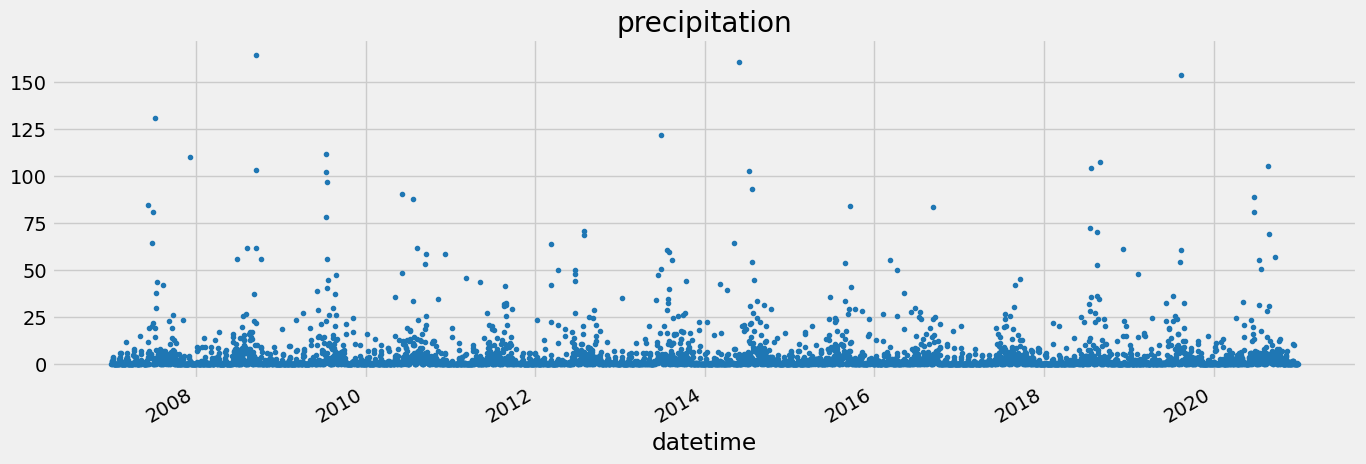

In [30]:
df['predicted_data'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='precipitation')
plt.show()

In [31]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

# # Define the parameter grid for tuning
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 500, 1000],
# }

# # Initialize TimeSeriesSplit
# tss = TimeSeriesSplit(n_splits=5, test_size=1*365*1, gap=1)

# # Initialize lists to store predictions and scores
# preds = []
# scores = []

# # Iterate through each fold
# for fold, (train_idx, val_idx) in enumerate(tss.split(df)):
#     # Split data into training and validation sets
#     train = df.iloc[train_idx]
#     test = df.iloc[val_idx]

#     # Create features for training and validation sets
#     train = create_features(train)
#     test = create_features(test)

#     # Define features and target variable
#     FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
#     TARGET = 'obs'

#     # Extract features and target variable for training and validation sets
#     X_train = train[FEATURES]
#     y_train = train[TARGET]
#     X_test = test[FEATURES]
#     y_test = test[TARGET]

#     # Initialize XGBoost regressor
#     reg = xgb.XGBRegressor(base_score=0, booster='gbtree', objective='reg:linear')

#     # Perform grid search or randomized search for parameter tuning
#     grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
#     grid_search.fit(X_train, y_train)

#     # Get the best estimator from the grid search
#     best_reg = grid_search.best_estimator_

#     # Fit the model with the best parameters
#     best_reg.fit(X_train, y_train,
#                  eval_set=[(X_train, y_train), (X_test, y_test)],
#                  verbose=100)

#     # Make predictions on the validation set
#     y_pred = best_reg.predict(X_test)
#     preds.append(y_pred)

#     # Calculate RMSE
#     score = np.sqrt(mean_squared_error(y_test, y_pred))
#     scores.append(score)

#     print("Fold:", fold+1, "RMSE:", score)

# # Calculate mean RMSE across all folds
# mean_rmse = np.mean(scores)
# print("Mean RMSE:", mean_rmse)


In [32]:
mean_rmse = np.mean(scores)
print("Mean RMSE:", mean_rmse)

Mean RMSE: 8.391778736850785
